In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as spr
import gurobipy as grb

data_X = pd.read_csv("https://github.com/math-econ-code/mec_optim_2021-01/raw/master/data_mec_optim/marriage_personality-traits/Xvals.csv")
data_Y = pd.read_csv("https://github.com/math-econ-code/mec_optim_2021-01/raw/master/data_mec_optim/marriage_personality-traits/Yvals.csv")
data_affmat = pd.read_csv("https://github.com/math-econ-code/mec_optim_2021-01/raw/master/data_mec_optim/marriage_personality-traits/affinitymatrix.csv")

In [3]:
class random_panel:
    def __init__(self, init_matrix, time, speed=1):
        self.time = time
        self.init_matrix = init_matrix
        self.speed = speed
    def generate(self):
        X_panel = np.empty((self.time, self.init_matrix.shape[0], self.init_matrix.shape[1]))
        X_panel[0, :, :] = self.init_matrix
        for i in range(self.time - 1):
            X_panel[i+1, :, :] = X_panel[i, :, :] + self.speed * np.random.randn(self.init_matrix.shape[0], self.init_matrix.shape[1])
        return X_panel

In [4]:
np.random.seed(42)
n = 10
t = 10
speed = 1

sdX = data_X.std().to_numpy()
sdY = data_Y.std().to_numpy()
mX = data_X.mean().to_numpy()
mY = data_Y.mean().to_numpy()

affmat = data_affmat.to_numpy()[0: 10, 1:]
Xvals = ((data_X-mX)/sdX).to_numpy()[0:n, :]
Yvals = ((data_Y-mY)/sdY).to_numpy()[0:n, :]


Xvals_dyna = random_panel(Xvals, t, speed).generate()
Yvals_dyna = random_panel(Yvals.T, t, speed).generate()
phi_dyna = Xvals_dyna @ affmat @ Yvals_dyna

In [5]:
class dynamic_matching_no_information:
    def __init__(self, phi, cost, cost_type):
        self.phi = phi
        self.C = cost
        self.n = phi.shape[1]
        self.t = phi.shape[0]
        self.vecphi = self.phi.flatten()
        self.cost_type = cost_type
    def optimize(self):
        phi_t = self.phi[0, :, :]
        vecphi_t = phi_t.flatten()
        sparse_one = spr.csr_matrix(np.ones(self.n).reshape(1, self.n))
        p_t = np.ones((self.n, 1))/self.n
        q_t = np.ones((self.n, 1))/self.n
        d_t = np.concatenate((p_t, q_t), axis=None)

        A_loop = spr.kron(sparse_one, spr.identity(self.n))
        B_loop = spr.kron(spr.identity(self.n), sparse_one)
        Aconstr_loop = spr.vstack([A_loop, B_loop])

        self.pi_panel_loop = np.empty((self.t, self.n, self.n))
        self.optimal_values_loop = []
        for iteration in range(self.t):
            p = grb.Model('Optimal Coupling with reassignment cost')
            x = p.addMVar(shape = self.n**2, name = 'x')
            p.setObjective(vecphi_t @ x, grb.GRB.MAXIMIZE)
            p.addConstr(Aconstr_loop @ x == d_t)
            p.setParam('OutputFlag', False)
            p.optimize()
            if p.status == grb.GRB.Status.OPTIMAL:
                self.optimal_values_loop.append((self.phi[iteration, :, :]).flatten() @ p.getAttr('x'))
                matpi_t = np.array(p.getAttr('x')).reshape(self.n, self.n)
                self.pi_panel_loop[iteration, :, :] = matpi_t
            if iteration < self.t - 1 and (self.cost_type == 'Fixed' or self.cost_type == 'fixed'):
                vecphi_t = (self.phi[iteration + 1, :, :] + (self.C * matpi_t)).flatten()
            elif iteration < self.t - 1 and (self.cost_type == 'Variable' or self.cost_type == 'variable'):
                vecphi_t = (self.phi[iteration + 1, :, :] + (self.C * matpi_t * self.phi[iteration, :, :])).flatten()

        self.pi_loop_surplus = np.sum(self.optimal_values_loop)
        
    def surplus(self):
        print('With', self.cost_type, 'reassignment cost ', self.C ,', the surplus generated is', self.pi_loop_surplus)
        
    def surplus_loss(self):
        p = np.ones((self.t, self.n, 1))/self.n
        q = np.ones((self.t, self.n, 1))/self.n
        d = np.concatenate((p,q), axis = None)

        sparse_one = spr.csr_matrix(np.ones(self.n).reshape(1, self.n))

        A = spr.kron(spr.identity(self.n*self.t), sparse_one)
        B = spr.kron(spr.kron(spr.identity(self.t), sparse_one), spr.identity(self.n))
        Aconstr = spr.vstack([A, B])

        m=grb.Model('Optimal Marriage')
        x = m.addMVar(shape=self.t * self.n**2, name="x")
        m.setObjective(self.vecphi @ x, grb.GRB.MAXIMIZE)
        m.setParam('OutputFlag', False)
        m.addConstr(Aconstr @ x == d, name="Constr")
        m.optimize()

        if m.status == grb.GRB.Status.OPTIMAL:
            pi_surplus = self.vecphi @ m.getAttr('x')
        self.surplus_loss_l = pi_surplus - self.pi_loop_surplus
        print('The surplus loss is of ', (self.surplus_loss_l/pi_surplus)*100, '% due to the reassignment cost')
        
    def matching_of_man(self, man):
        for time in range(self.t):
            if np.all(self.pi_panel_loop[time, man - 1, :] == 0):
                print('Period', time+1, ': Single')
            else:
                print('Period', time+1, ': Woman', np.argwhere(self.pi_panel_loop[time, man-1,:] != 0)[0][0] + 1)
        
    def matching_graph(self):
        plt.rcParams["figure.figsize"] = (20, 6)
        self.matchings = np.empty((self.t, self.n))
        for time in range(self.t):
            self.matchings[time, :] = np.argwhere(self.pi_panel_loop[time, : ,:] != 0)[:, 1] + 1
        plt.plot(self.matchings)
        plt.show()

Academic license - for non-commercial use only - expires 2021-10-25
Using license file c:\gurobi911\gurobi.lic
With fixed reassignment cost  5 , the surplus generated is 56.659456841418255
The surplus loss is of  0.6483340457400193 % due to the reassignment cost


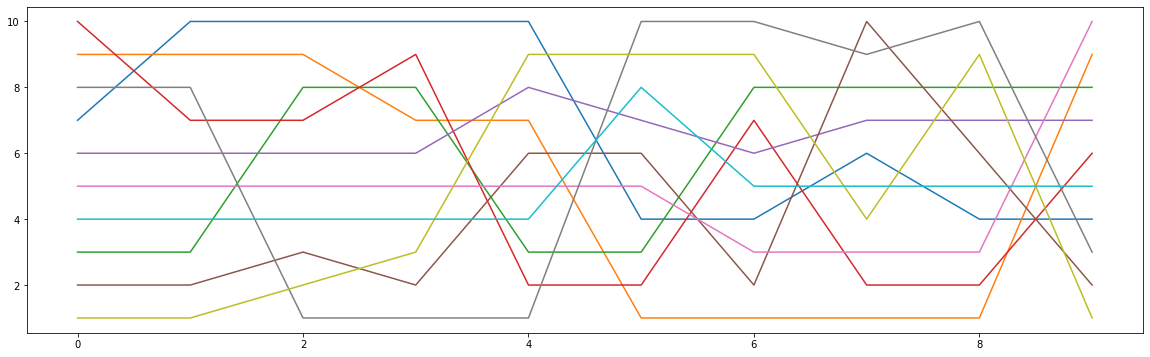

In [6]:
test_no_inf_fixed = dynamic_matching_no_information(phi_dyna, 5, cost_type='fixed')
test_no_inf_fixed.optimize()
test_no_inf_fixed.surplus()
test_no_inf_fixed.surplus_loss()
test_no_inf_fixed.matching_graph()